In [86]:
def get_colour():
    global robopose
    global shipmap
    
    coord = (robopose[0], robopose[1])
    if coord in shipmap:
        return shipmap[coord][0]
    else:
        shipmap[coord] = [0, 0]
        return 0
    
def move_robot(steer):
    global robopose
    if steer == 0:
        heading = (robopose[2] + 1) % 4
    elif steer == 1:
        heading = (robopose[2] - 1 + 4) % 4
    else:
        heading = robopose[2]
        print('invalid steering')
    robopose[2] = heading
    
    if heading == 0:
        robopose[0] += 1
    elif heading == 1:
        robopose[1] += 1
    elif heading == 2:
        robopose[0] -= 1
    elif heading == 3:
        robopose[1] -= 1
    else:
        print('{} is not a valid heading'.format(heading))

In [87]:
def resolve_arg(program, argmode, base_offset, i, j):    
    if argmode == 0:
        return program[i+j]
    elif argmode == 1:
        return i+j
    elif argmode == 2:
        return base_offset + program[i+j]

def intcode(program, inlist=[], i=0):
    global shipmap
    global robopose
    mode = 'paint'
    outbuf = []
    base_offset = 0
    
    running_paintcount = 0
    exclusive_paintcount = 0
    global paintlist
    
    while True:
        if i >= len(program):
            print('end of program')
            return program
        opcode = program[i]
        
#         print(i, opcode, base_offset)
        
        op = opcode % 100
        argmodes = []
        argcode = opcode // 100
        while argcode > 0:
            argmodes.append(argcode % 10)
            argcode = argcode // 10
            
        # ADD A B -> C
        # --------------------------------------------------------
        if op == 1:
            if len(argmodes) < 1:
                idx1 = resolve_arg(program, 0, base_offset, i, 1)
            else:
                idx1 = resolve_arg(program, argmodes[0], base_offset, i, 1)
            
            if len(argmodes) < 2:
                idx2 = resolve_arg(program, 0, base_offset, i, 2)
            else:
                idx2 = resolve_arg(program, argmodes[1], base_offset, i, 2)
            
            if len(argmodes) < 3:
                idx3 = resolve_arg(program, 0, base_offset, i, 3)
            else:
                idx3 = resolve_arg(program, argmodes[2], base_offset, i, 3)

            bigdex = max([idx1, idx2, idx3])
            if len(program) <= bigdex:
                program += [0]*(bigdex - len(program) + 1)
                
            arg1 = program[idx1]
            arg2 = program[idx2]                
            
            program[idx3] = arg1 + arg2
            i += 4
        # MULTIPLY A B ->
        # --------------------------------------------------------
        elif op == 2:
            if len(argmodes) < 1:
                idx1 = resolve_arg(program, 0, base_offset, i, 1)
            else:
                idx1 = resolve_arg(program, argmodes[0], base_offset, i, 1)
            
            
            if len(argmodes) < 2:
                idx2 = resolve_arg(program, 0, base_offset, i, 2)
            else:
                idx2 = resolve_arg(program, argmodes[1], base_offset, i, 2)

            if len(argmodes) < 3:
                idx3 = resolve_arg(program, 0, base_offset, i, 3)
            else:
                idx3 = resolve_arg(program, argmodes[2], base_offset, i, 3)
                
            bigdex = max([idx1, idx2, idx3])
            if len(program) <= bigdex:
                program += [0]*(bigdex - len(program) + 1)
                
            arg1 = program[idx1]
            arg2 = program[idx2]
            
            program[idx3] = arg1 * arg2
            i += 4
        # INPUT -> A
        # --------------------------------------------------------
        elif op == 3:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            
            if len(program) <= idx:
                program += [0]*(idx - len(program) + 1)

            if len(inlist) > 0:
                program[idx] = inlist[0]
                inlist = inlist[1:]
            else:
                program[idx] = get_colour()
            i += 2
        # OUTPUT A
        # --------------------------------------------------------
        elif op == 4:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            outbuf.append(program[idx])
            
            if mode == 'paint':
                coord = (robopose[0], robopose[1])
                paintcount = shipmap[coord][1]
                currnpaint = shipmap[coord][0]
                paintcount += 1
                
                paintlist.append(coord)
                if not coord in paintlist:
                    exclusive_paintcount += 1
                running_paintcount += 1
                
                shipmap[coord] = [program[idx], paintcount]
                mode = 'move'
                print('{}, {} paint'.format(running_paintcount, exclusive_paintcount),
                      program[idx], 'at', coord)
            elif mode == 'move':
                move_robot(program[idx])
                mode = 'paint'
#                 print('{} move to'.format(program[idx]), robopose)
                
            i += 2
        # JUMP TRUE A != 0 -> B
        # --------------------------------------------------------
        elif op == 5:                
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx1 = resolve_arg(program, argmode, base_offset, i, 1)
            
            argmode = 0 if len(argmodes) < 2 else argmodes[1]
            idx2 = resolve_arg(program, argmode, base_offset, i, 2)
            
            bigdex = max([idx1, idx2])
            if len(program) <= bigdex:
                program += [0]*(bigdex - len(program) + 1)
            
            arg1 = program[idx1]
            arg2 = program[idx2]    
            if arg1 != 0:
                i = arg2
            else:
                i += 3
        # JUMP FALSE A == 0 -> B
        # --------------------------------------------------------
        elif op == 6:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            arg1 = program[idx]
            
            argmode = 0 if len(argmodes) < 2 else argmodes[1]
            idx = resolve_arg(program, argmode, base_offset, i, 2)
            arg2 = program[idx]
            
            if len(program) <= arg2:
                program += [0]*(arg2-len(program)+1)
                
            if arg1 == 0:
                i = arg2
            else:
                i += 3
        # LESS THAN A < B 1 -> C
        # --------------------------------------------------------
        elif op == 7:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            arg1 = program[idx]
            
            argmode = 0 if len(argmodes) < 2 else argmodes[1]
            idx = resolve_arg(program, argmode, base_offset, i, 2)
            arg2 = program[idx]
            
            argmode = 0 if len(argmodes) < 3 else argmodes[2]
            idx = resolve_arg(program, argmode, base_offset, i, 3)
#             arg3 = program[idx]
                
            if len(program) <= idx:
                program += [0]*(idx-len(program)+1)
                
            if arg1 < arg2:
                program[idx] = 1
            else:
                program[idx] = 0
            i += 4
        # EQUALS A == B 1 -> C
        # --------------------------------------------------------
        elif op == 8:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            arg1 = program[idx]
            
            argmode = 0 if len(argmodes) < 2 else argmodes[1]
            idx = resolve_arg(program, argmode, base_offset, i, 2)
            arg2 = program[idx]
            
            argmode = 0 if len(argmodes) < 3 else argmodes[2]
            idx = resolve_arg(program, argmode, base_offset, i, 3)
#             arg3 = program[idx]
                
            if len(program) <= idx:
                program += [0]*(idx-len(program)+1)
                
            if arg1 == arg2:
                program[idx] = 1
            else:
                program[idx] = 0
            i += 4
        # SHIFT RELATIVE BASE
        # --------------------------------------------------------
        elif op == 9:
            argmode = 0 if len(argmodes) < 1 else argmodes[0]
            idx = resolve_arg(program, argmode, base_offset, i, 1)
            arg1 = program[idx]
            base_offset += arg1
            if len(program) <= base_offset:
                program += [0]*(base_offset-len(program)+1)
            i += 2
        # HALT
        # --------------------------------------------------------
        elif op == 99:
            return -1, i, outbuf
        # INVALID
        # --------------------------------------------------------
        else:
            print(program[i], 'is not an instruction')
            return -1, i, outbuf

In [100]:
shipmap = {(0, 0): [0, 0]}
robopose = [0, 0, 0]
paintlist = []

with open('calca_11_input.txt', 'r') as instr:
    rawprog = [r for r in instr][0]
program = [int(c) for c in rawprog.split(',')]

out = intcode(program)
print(robopose)

1, 0 paint 1 at (0, 0)
2, 0 paint 1 at (0, 1)
3, 0 paint 1 at (1, 1)
4, 0 paint 1 at (1, 2)
5, 0 paint 1 at (0, 2)
6, 0 paint 1 at (0, 3)
7, 0 paint 1 at (-1, 3)
8, 0 paint 1 at (-1, 2)
9, 0 paint 1 at (-2, 2)
10, 0 paint 1 at (-2, 1)
11, 0 paint 1 at (-3, 1)
12, 0 paint 1 at (-3, 2)
13, 0 paint 0 at (-2, 2)
14, 0 paint 1 at (-2, 3)
15, 0 paint 0 at (-1, 3)
16, 0 paint 1 at (-1, 4)
17, 0 paint 1 at (0, 4)
18, 0 paint 0 at (0, 3)
19, 0 paint 1 at (1, 3)
20, 0 paint 0 at (1, 2)
21, 0 paint 1 at (2, 2)
22, 0 paint 1 at (2, 1)
23, 0 paint 0 at (1, 1)
24, 0 paint 1 at (1, 2)
25, 0 paint 0 at (2, 2)
26, 0 paint 0 at (2, 1)
27, 0 paint 1 at (3, 1)
28, 0 paint 1 at (3, 0)
29, 0 paint 1 at (4, 0)
30, 0 paint 1 at (4, -1)
31, 0 paint 1 at (5, -1)
32, 0 paint 1 at (5, -2)
33, 0 paint 1 at (4, -2)
34, 0 paint 1 at (4, -3)
35, 0 paint 1 at (3, -3)
36, 0 paint 1 at (3, -4)
37, 0 paint 1 at (4, -4)
38, 0 paint 1 at (4, -5)
39, 0 paint 1 at (3, -5)
40, 0 paint 0 at (3, -4)
41, 0 paint 1 at (2, -4)
42,

739, 0 paint 1 at (-1, -15)
740, 0 paint 0 at (-1, -16)
741, 0 paint 1 at (-2, -16)
742, 0 paint 0 at (-2, -15)
743, 0 paint 1 at (-3, -15)
744, 0 paint 1 at (-3, -16)
745, 0 paint 1 at (-4, -16)
746, 0 paint 1 at (-4, -17)
747, 0 paint 1 at (-5, -17)
748, 0 paint 1 at (-5, -16)
749, 0 paint 0 at (-4, -16)
750, 0 paint 1 at (-4, -15)
751, 0 paint 1 at (-5, -15)
752, 0 paint 1 at (-5, -14)
753, 0 paint 1 at (-6, -14)
754, 0 paint 1 at (-6, -13)
755, 0 paint 1 at (-5, -13)
756, 0 paint 0 at (-5, -14)
757, 0 paint 1 at (-4, -14)
758, 0 paint 0 at (-4, -15)
759, 0 paint 0 at (-3, -15)
760, 0 paint 0 at (-3, -16)
761, 0 paint 0 at (-2, -16)
762, 0 paint 1 at (-2, -15)
763, 0 paint 0 at (-1, -15)
764, 0 paint 0 at (-1, -14)
765, 0 paint 0 at (-2, -14)
766, 0 paint 0 at (-2, -15)
767, 0 paint 1 at (-3, -15)
768, 0 paint 1 at (-3, -14)
769, 0 paint 0 at (-4, -14)
770, 0 paint 1 at (-4, -13)
771, 0 paint 0 at (-5, -13)
772, 0 paint 1 at (-5, -12)
773, 0 paint 1 at (-4, -12)
774, 0 paint 1 at (-

1525, 0 paint 0 at (6, -18)
1526, 0 paint 0 at (6, -17)
1527, 0 paint 0 at (7, -17)
1528, 0 paint 1 at (7, -16)
1529, 0 paint 0 at (6, -16)
1530, 0 paint 1 at (6, -17)
1531, 0 paint 1 at (7, -17)
1532, 0 paint 1 at (7, -18)
1533, 0 paint 1 at (6, -18)
1534, 0 paint 0 at (6, -17)
1535, 0 paint 0 at (7, -17)
1536, 0 paint 0 at (7, -18)
1537, 0 paint 0 at (6, -18)
1538, 0 paint 1 at (6, -17)
1539, 0 paint 1 at (7, -17)
1540, 0 paint 0 at (7, -16)
1541, 0 paint 1 at (6, -16)
1542, 0 paint 1 at (6, -15)
1543, 0 paint 0 at (7, -15)
1544, 0 paint 0 at (7, -14)
1545, 0 paint 1 at (8, -14)
1546, 0 paint 0 at (8, -13)
1547, 0 paint 0 at (9, -13)
1548, 0 paint 0 at (9, -14)
1549, 0 paint 1 at (10, -14)
1550, 0 paint 0 at (10, -15)
1551, 0 paint 1 at (9, -15)
1552, 0 paint 1 at (9, -14)
1553, 0 paint 0 at (10, -14)
1554, 0 paint 1 at (10, -15)
1555, 0 paint 0 at (11, -15)
1556, 0 paint 0 at (11, -14)
1557, 0 paint 0 at (12, -14)
1558, 0 paint 0 at (12, -15)
1559, 0 paint 1 at (11, -15)
1560, 0 pai

2308, 0 paint 0 at (-1, -22)
2309, 0 paint 1 at (0, -22)
2310, 0 paint 1 at (0, -23)
2311, 0 paint 0 at (1, -23)
2312, 0 paint 0 at (1, -24)
2313, 0 paint 1 at (0, -24)
2314, 0 paint 0 at (0, -23)
2315, 0 paint 1 at (1, -23)
2316, 0 paint 1 at (1, -22)
2317, 0 paint 0 at (0, -22)
2318, 0 paint 1 at (0, -21)
2319, 0 paint 1 at (-1, -21)
2320, 0 paint 0 at (-1, -20)
2321, 0 paint 1 at (-2, -20)
2322, 0 paint 1 at (-2, -21)
2323, 0 paint 0 at (-1, -21)
2324, 0 paint 1 at (-1, -20)
2325, 0 paint 0 at (-2, -20)
2326, 0 paint 0 at (-2, -21)
2327, 0 paint 1 at (-1, -21)
2328, 0 paint 0 at (-1, -20)
2329, 0 paint 1 at (-2, -20)
2330, 0 paint 0 at (-2, -19)
2331, 0 paint 1 at (-1, -19)
2332, 0 paint 1 at (-1, -20)
2333, 0 paint 0 at (-2, -20)
2334, 0 paint 1 at (-2, -19)
2335, 0 paint 0 at (-1, -19)
2336, 0 paint 0 at (-1, -20)
2337, 0 paint 1 at (-2, -20)
2338, 0 paint 0 at (-2, -19)
2339, 0 paint 1 at (-1, -19)
2340, 0 paint 1 at (-1, -20)
2341, 0 paint 1 at (0, -20)
2342, 0 paint 0 at (0, -2

2924, 0 paint 1 at (7, -32)
2925, 0 paint 0 at (8, -32)
2926, 0 paint 1 at (8, -31)
2927, 0 paint 1 at (9, -31)
2928, 0 paint 0 at (9, -32)
2929, 0 paint 1 at (10, -32)
2930, 0 paint 0 at (10, -33)
2931, 0 paint 1 at (11, -33)
2932, 0 paint 0 at (11, -34)
2933, 0 paint 1 at (12, -34)
2934, 0 paint 1 at (12, -35)
2935, 0 paint 0 at (11, -35)
2936, 0 paint 1 at (11, -34)
2937, 0 paint 0 at (12, -34)
2938, 0 paint 1 at (12, -33)
2939, 0 paint 0 at (11, -33)
2940, 0 paint 0 at (11, -34)
2941, 0 paint 0 at (10, -34)
2942, 0 paint 0 at (10, -35)
2943, 0 paint 1 at (9, -35)
2944, 0 paint 1 at (9, -34)
2945, 0 paint 1 at (10, -34)
2946, 0 paint 1 at (10, -33)
2947, 0 paint 1 at (11, -33)
2948, 0 paint 1 at (11, -32)
2949, 0 paint 1 at (12, -32)
2950, 0 paint 1 at (12, -31)
2951, 0 paint 1 at (11, -31)
2952, 0 paint 0 at (11, -32)
2953, 0 paint 0 at (10, -32)
2954, 0 paint 0 at (10, -33)
2955, 0 paint 0 at (11, -33)
2956, 0 paint 1 at (11, -32)
2957, 0 paint 0 at (12, -32)
2958, 0 paint 0 at (1

3556, 0 paint 1 at (13, -22)
3557, 0 paint 1 at (14, -22)
3558, 0 paint 0 at (14, -21)
3559, 0 paint 0 at (13, -21)
3560, 0 paint 0 at (13, -20)
3561, 0 paint 0 at (12, -20)
3562, 0 paint 0 at (12, -21)
3563, 0 paint 0 at (11, -21)
3564, 0 paint 1 at (11, -22)
3565, 0 paint 0 at (12, -22)
3566, 0 paint 1 at (12, -21)
3567, 0 paint 1 at (13, -21)
3568, 0 paint 0 at (13, -22)
3569, 0 paint 1 at (12, -22)
3570, 0 paint 1 at (12, -23)
3571, 0 paint 0 at (13, -23)
3572, 0 paint 0 at (13, -24)
3573, 0 paint 1 at (12, -24)
3574, 0 paint 0 at (12, -25)
3575, 0 paint 1 at (13, -25)
3576, 0 paint 1 at (13, -24)
3577, 0 paint 0 at (14, -24)
3578, 0 paint 0 at (14, -23)
3579, 0 paint 0 at (15, -23)
3580, 0 paint 0 at (15, -22)
3581, 0 paint 0 at (14, -22)
3582, 0 paint 1 at (14, -21)
3583, 0 paint 0 at (13, -21)
3584, 0 paint 1 at (13, -22)
3585, 0 paint 1 at (14, -22)
3586, 0 paint 1 at (14, -23)
3587, 0 paint 1 at (13, -23)
3588, 0 paint 0 at (13, -24)
3589, 0 paint 0 at (12, -24)
3590, 0 paint 

4149, 0 paint 1 at (16, -24)
4150, 0 paint 0 at (16, -23)
4151, 0 paint 0 at (17, -23)
4152, 0 paint 0 at (17, -24)
4153, 0 paint 0 at (16, -24)
4154, 0 paint 1 at (16, -23)
4155, 0 paint 1 at (17, -23)
4156, 0 paint 0 at (17, -22)
4157, 0 paint 0 at (16, -22)
4158, 0 paint 0 at (16, -23)
4159, 0 paint 0 at (17, -23)
4160, 0 paint 1 at (17, -22)
4161, 0 paint 1 at (16, -22)
4162, 0 paint 1 at (16, -23)
4163, 0 paint 1 at (17, -23)
4164, 0 paint 0 at (17, -22)
4165, 0 paint 0 at (16, -22)
4166, 0 paint 0 at (16, -23)
4167, 0 paint 1 at (15, -23)
4168, 0 paint 0 at (15, -24)
4169, 0 paint 1 at (14, -24)
4170, 0 paint 0 at (14, -25)
4171, 0 paint 0 at (15, -25)
4172, 0 paint 1 at (15, -24)
4173, 0 paint 1 at (16, -24)
4174, 0 paint 0 at (16, -25)
4175, 0 paint 1 at (15, -25)
4176, 0 paint 0 at (15, -26)
4177, 0 paint 0 at (14, -26)
4178, 0 paint 0 at (14, -27)
4179, 0 paint 0 at (13, -27)
4180, 0 paint 1 at (13, -28)
4181, 0 paint 1 at (14, -28)
4182, 0 paint 1 at (14, -27)
4183, 0 paint 

4778, 0 paint 0 at (0, -39)
4779, 0 paint 0 at (-1, -39)
4780, 0 paint 0 at (-1, -40)
4781, 0 paint 0 at (-2, -40)
4782, 0 paint 1 at (-2, -41)
4783, 0 paint 1 at (-3, -41)
4784, 0 paint 1 at (-3, -42)
4785, 0 paint 0 at (-4, -42)
4786, 0 paint 0 at (-4, -43)
4787, 0 paint 1 at (-5, -43)
4788, 0 paint 0 at (-5, -42)
4789, 0 paint 1 at (-4, -42)
4790, 0 paint 1 at (-4, -41)
4791, 0 paint 0 at (-5, -41)
4792, 0 paint 0 at (-5, -40)
4793, 0 paint 1 at (-6, -40)
4794, 0 paint 0 at (-6, -39)
4795, 0 paint 0 at (-7, -39)
4796, 0 paint 0 at (-7, -38)
4797, 0 paint 0 at (-6, -38)
4798, 0 paint 1 at (-6, -37)
4799, 0 paint 1 at (-7, -37)
4800, 0 paint 1 at (-7, -36)
4801, 0 paint 1 at (-6, -36)
4802, 0 paint 1 at (-6, -35)
4803, 0 paint 1 at (-7, -35)
4804, 0 paint 1 at (-7, -34)
4805, 0 paint 1 at (-8, -34)
4806, 0 paint 1 at (-8, -35)
4807, 0 paint 0 at (-7, -35)
4808, 0 paint 0 at (-7, -36)
4809, 0 paint 0 at (-6, -36)
4810, 0 paint 0 at (-6, -35)
4811, 0 paint 1 at (-7, -35)
4812, 0 paint 0

5371, 0 paint 1 at (5, -43)
5372, 0 paint 1 at (5, -42)
5373, 0 paint 0 at (6, -42)
5374, 0 paint 0 at (6, -43)
5375, 0 paint 0 at (7, -43)
5376, 0 paint 0 at (7, -44)
5377, 0 paint 1 at (8, -44)
5378, 0 paint 1 at (8, -45)
5379, 0 paint 1 at (7, -45)
5380, 0 paint 1 at (7, -44)
5381, 0 paint 0 at (8, -44)
5382, 0 paint 0 at (8, -43)
5383, 0 paint 1 at (7, -43)
5384, 0 paint 0 at (7, -44)
5385, 0 paint 0 at (6, -44)
5386, 0 paint 1 at (6, -43)
5387, 0 paint 0 at (5, -43)
5388, 0 paint 1 at (5, -44)
5389, 0 paint 0 at (4, -44)
5390, 0 paint 1 at (4, -45)
5391, 0 paint 1 at (3, -45)
5392, 0 paint 1 at (3, -46)
5393, 0 paint 1 at (4, -46)
5394, 0 paint 1 at (4, -47)
5395, 0 paint 1 at (5, -47)
5396, 0 paint 1 at (5, -46)
5397, 0 paint 1 at (6, -46)
5398, 0 paint 1 at (6, -45)
5399, 0 paint 0 at (7, -45)
5400, 0 paint 1 at (7, -46)
5401, 0 paint 0 at (6, -46)
5402, 0 paint 1 at (6, -47)
5403, 0 paint 0 at (5, -47)
5404, 0 paint 1 at (5, -48)
5405, 0 paint 1 at (4, -48)
5406, 0 paint 0 at (

5971, 0 paint 1 at (-9, -29)
5972, 0 paint 1 at (-9, -28)
5973, 0 paint 1 at (-8, -28)
5974, 0 paint 0 at (-8, -29)
5975, 0 paint 1 at (-7, -29)
5976, 0 paint 1 at (-7, -28)
5977, 0 paint 0 at (-8, -28)
5978, 0 paint 1 at (-8, -29)
5979, 0 paint 0 at (-7, -29)
5980, 0 paint 1 at (-7, -30)
5981, 0 paint 1 at (-8, -30)
5982, 0 paint 0 at (-8, -29)
5983, 0 paint 0 at (-9, -29)
5984, 0 paint 0 at (-9, -30)
5985, 0 paint 1 at (-10, -30)
5986, 0 paint 1 at (-10, -29)
5987, 0 paint 1 at (-9, -29)
5988, 0 paint 0 at (-9, -28)
5989, 0 paint 1 at (-10, -28)
5990, 0 paint 0 at (-10, -29)
5991, 0 paint 0 at (-9, -29)
5992, 0 paint 1 at (-9, -28)
5993, 0 paint 0 at (-10, -28)
5994, 0 paint 1 at (-10, -27)
5995, 0 paint 1 at (-11, -27)
5996, 0 paint 1 at (-11, -26)
5997, 0 paint 1 at (-10, -26)
5998, 0 paint 0 at (-10, -27)
5999, 0 paint 0 at (-11, -27)
6000, 0 paint 1 at (-11, -28)
6001, 0 paint 1 at (-10, -28)
6002, 0 paint 1 at (-10, -27)
6003, 0 paint 1 at (-9, -27)
6004, 0 paint 1 at (-9, -26)


6562, 0 paint 1 at (0, -31)
6563, 0 paint 0 at (-1, -31)
6564, 0 paint 1 at (-1, -32)
6565, 0 paint 0 at (0, -32)
6566, 0 paint 0 at (0, -31)
6567, 0 paint 1 at (-1, -31)
6568, 0 paint 1 at (-1, -30)
6569, 0 paint 0 at (-2, -30)
6570, 0 paint 1 at (-2, -29)
6571, 0 paint 1 at (-3, -29)
6572, 0 paint 1 at (-3, -28)
6573, 0 paint 1 at (-2, -28)
6574, 0 paint 0 at (-2, -27)
6575, 0 paint 0 at (-3, -27)
6576, 0 paint 0 at (-3, -26)
6577, 0 paint 1 at (-2, -26)
6578, 0 paint 1 at (-2, -27)
6579, 0 paint 1 at (-3, -27)
6580, 0 paint 0 at (-3, -28)
6581, 0 paint 0 at (-2, -28)
6582, 0 paint 0 at (-2, -27)
6583, 0 paint 0 at (-3, -27)
6584, 0 paint 1 at (-3, -28)
6585, 0 paint 1 at (-2, -28)
6586, 0 paint 1 at (-2, -27)
6587, 0 paint 1 at (-3, -27)
6588, 0 paint 1 at (-3, -26)
6589, 0 paint 0 at (-2, -26)
6590, 0 paint 1 at (-2, -25)
6591, 0 paint 0 at (-3, -25)
6592, 0 paint 0 at (-3, -24)
6593, 0 paint 1 at (-2, -24)
6594, 0 paint 1 at (-2, -23)
6595, 0 paint 1 at (-1, -23)
6596, 0 paint 1 a

7131, 0 paint 1 at (-11, -21)
7132, 0 paint 1 at (-11, -22)
7133, 0 paint 1 at (-10, -22)
7134, 0 paint 0 at (-10, -23)
7135, 0 paint 0 at (-11, -23)
7136, 0 paint 0 at (-11, -24)
7137, 0 paint 0 at (-10, -24)
7138, 0 paint 0 at (-10, -25)
7139, 0 paint 0 at (-9, -25)
7140, 0 paint 1 at (-9, -26)
7141, 0 paint 0 at (-8, -26)
7142, 0 paint 1 at (-8, -25)
7143, 0 paint 0 at (-7, -25)
7144, 0 paint 0 at (-7, -24)
7145, 0 paint 0 at (-6, -24)
7146, 0 paint 0 at (-6, -25)
7147, 0 paint 1 at (-7, -25)
7148, 0 paint 0 at (-7, -26)
7149, 0 paint 1 at (-8, -26)
7150, 0 paint 1 at (-8, -27)
7151, 0 paint 0 at (-9, -27)
7152, 0 paint 0 at (-9, -26)
7153, 0 paint 1 at (-10, -26)
7154, 0 paint 1 at (-10, -27)
7155, 0 paint 1 at (-9, -27)
7156, 0 paint 1 at (-9, -26)
7157, 0 paint 0 at (-10, -26)
7158, 0 paint 0 at (-10, -27)
7159, 0 paint 1 at (-11, -27)
7160, 0 paint 0 at (-11, -26)
7161, 0 paint 0 at (-12, -26)
7162, 0 paint 1 at (-12, -25)
7163, 0 paint 1 at (-13, -25)
7164, 0 paint 0 at (-13, -

7564, 0 paint 1 at (-15, -24)
7565, 0 paint 1 at (-16, -24)
7566, 0 paint 1 at (-16, -25)
7567, 0 paint 0 at (-17, -25)
7568, 0 paint 1 at (-17, -24)
7569, 0 paint 0 at (-18, -24)
7570, 0 paint 0 at (-18, -25)
7571, 0 paint 1 at (-19, -25)
7572, 0 paint 0 at (-19, -24)
7573, 0 paint 1 at (-20, -24)
7574, 0 paint 0 at (-20, -25)
7575, 0 paint 0 at (-19, -25)
7576, 0 paint 1 at (-19, -24)
7577, 0 paint 1 at (-18, -24)
7578, 0 paint 1 at (-18, -23)
7579, 0 paint 1 at (-17, -23)
7580, 0 paint 1 at (-17, -22)
7581, 0 paint 1 at (-18, -22)
7582, 0 paint 1 at (-18, -21)
7583, 0 paint 1 at (-19, -21)
7584, 0 paint 1 at (-19, -20)
7585, 0 paint 1 at (-20, -20)
7586, 0 paint 1 at (-20, -21)
7587, 0 paint 1 at (-21, -21)
7588, 0 paint 1 at (-21, -20)
7589, 0 paint 0 at (-20, -20)
7590, 0 paint 1 at (-20, -19)
7591, 0 paint 1 at (-19, -19)
7592, 0 paint 0 at (-19, -20)
7593, 0 paint 1 at (-18, -20)
7594, 0 paint 0 at (-18, -21)
7595, 0 paint 1 at (-17, -21)
7596, 0 paint 0 at (-17, -22)
7597, 0 pa

7952, 0 paint 0 at (13, -32)
7953, 0 paint 0 at (12, -32)
7954, 0 paint 0 at (12, -33)
7955, 0 paint 1 at (11, -33)
7956, 0 paint 0 at (11, -34)
7957, 0 paint 0 at (12, -34)
7958, 0 paint 0 at (12, -35)
7959, 0 paint 1 at (13, -35)
7960, 0 paint 1 at (13, -36)
7961, 0 paint 1 at (12, -36)
7962, 0 paint 1 at (12, -37)
7963, 0 paint 1 at (13, -37)
7964, 0 paint 0 at (13, -36)
7965, 0 paint 0 at (14, -36)
7966, 0 paint 0 at (14, -35)
7967, 0 paint 1 at (15, -35)
7968, 0 paint 0 at (15, -34)
7969, 0 paint 0 at (16, -34)
7970, 0 paint 1 at (16, -33)
7971, 0 paint 1 at (17, -33)
7972, 0 paint 0 at (17, -34)
7973, 0 paint 0 at (18, -34)
7974, 0 paint 1 at (18, -33)
7975, 0 paint 0 at (17, -33)
7976, 0 paint 0 at (17, -32)
7977, 0 paint 0 at (18, -32)
7978, 0 paint 0 at (18, -31)
7979, 0 paint 0 at (19, -31)
7980, 0 paint 0 at (19, -32)
7981, 0 paint 1 at (20, -32)
7982, 0 paint 1 at (20, -33)
7983, 0 paint 1 at (21, -33)
7984, 0 paint 1 at (21, -32)
7985, 0 paint 1 at (22, -32)
7986, 0 paint 

8364, 0 paint 1 at (7, -38)
8365, 0 paint 0 at (6, -38)
8366, 0 paint 0 at (6, -37)
8367, 0 paint 1 at (5, -37)
8368, 0 paint 1 at (5, -36)
8369, 0 paint 1 at (4, -36)
8370, 0 paint 1 at (4, -35)
8371, 0 paint 0 at (3, -35)
8372, 0 paint 0 at (3, -34)
8373, 0 paint 1 at (2, -34)
8374, 0 paint 1 at (2, -35)
8375, 0 paint 0 at (1, -35)
8376, 0 paint 1 at (1, -34)
8377, 0 paint 1 at (0, -34)
8378, 0 paint 0 at (0, -33)
8379, 0 paint 1 at (-1, -33)
8380, 0 paint 1 at (-1, -32)
8381, 0 paint 0 at (0, -32)
8382, 0 paint 1 at (0, -33)
8383, 0 paint 0 at (1, -33)
8384, 0 paint 0 at (1, -32)
8385, 0 paint 1 at (0, -32)
8386, 0 paint 0 at (0, -33)
8387, 0 paint 1 at (1, -33)
8388, 0 paint 0 at (1, -34)
8389, 0 paint 0 at (0, -34)
8390, 0 paint 0 at (0, -35)
8391, 0 paint 1 at (1, -35)
8392, 0 paint 1 at (1, -34)
8393, 0 paint 0 at (2, -34)
8394, 0 paint 0 at (2, -35)
8395, 0 paint 0 at (1, -35)
8396, 0 paint 1 at (1, -36)
8397, 0 paint 0 at (2, -36)
8398, 0 paint 1 at (2, -35)
8399, 0 paint 1 at

8879, 0 paint 1 at (25, -27)
8880, 0 paint 1 at (25, -28)
8881, 0 paint 1 at (26, -28)
8882, 0 paint 1 at (26, -29)
8883, 0 paint 0 at (27, -29)
8884, 0 paint 1 at (27, -28)
8885, 0 paint 1 at (28, -28)
8886, 0 paint 1 at (28, -29)
8887, 0 paint 1 at (29, -29)
8888, 0 paint 0 at (29, -28)
8889, 0 paint 1 at (30, -28)
8890, 0 paint 0 at (30, -29)
8891, 0 paint 0 at (31, -29)
8892, 0 paint 0 at (31, -28)
8893, 0 paint 0 at (30, -28)
8894, 0 paint 1 at (30, -27)
8895, 0 paint 1 at (31, -27)
8896, 0 paint 1 at (31, -28)
8897, 0 paint 1 at (30, -28)
8898, 0 paint 0 at (30, -27)
8899, 0 paint 0 at (31, -27)
8900, 0 paint 0 at (31, -26)
8901, 0 paint 1 at (32, -26)
8902, 0 paint 0 at (32, -25)
8903, 0 paint 1 at (33, -25)
8904, 0 paint 1 at (33, -24)
8905, 0 paint 1 at (34, -24)
8906, 0 paint 1 at (34, -25)
8907, 0 paint 0 at (33, -25)
8908, 0 paint 1 at (33, -26)
8909, 0 paint 1 at (34, -26)
8910, 0 paint 0 at (34, -25)
8911, 0 paint 1 at (35, -25)
8912, 0 paint 1 at (35, -26)
8913, 0 paint 

9419, 0 paint 0 at (11, -39)
9420, 0 paint 0 at (11, -38)
9421, 0 paint 1 at (12, -38)
9422, 0 paint 0 at (12, -37)
9423, 0 paint 1 at (11, -37)
9424, 0 paint 0 at (11, -36)
9425, 0 paint 1 at (12, -36)
9426, 0 paint 1 at (12, -37)
9427, 0 paint 0 at (13, -37)
9428, 0 paint 0 at (13, -38)
9429, 0 paint 0 at (14, -38)
9430, 0 paint 1 at (14, -39)
9431, 0 paint 0 at (15, -39)
9432, 0 paint 0 at (15, -38)
9433, 0 paint 0 at (16, -38)
9434, 0 paint 0 at (16, -37)
9435, 0 paint 0 at (17, -37)
9436, 0 paint 1 at (17, -36)
9437, 0 paint 1 at (18, -36)
9438, 0 paint 0 at (18, -35)
9439, 0 paint 1 at (19, -35)
9440, 0 paint 0 at (19, -34)
9441, 0 paint 0 at (18, -34)
9442, 0 paint 0 at (18, -33)
9443, 0 paint 1 at (19, -33)
9444, 0 paint 1 at (19, -32)
9445, 0 paint 1 at (18, -32)
9446, 0 paint 1 at (18, -33)
9447, 0 paint 0 at (17, -33)
9448, 0 paint 1 at (17, -34)
9449, 0 paint 1 at (18, -34)
9450, 0 paint 1 at (18, -35)
9451, 0 paint 0 at (19, -35)
9452, 0 paint 0 at (19, -36)
9453, 0 paint 

10045, 0 paint 1 at (28, -20)
10046, 0 paint 1 at (28, -19)
10047, 0 paint 1 at (29, -19)
10048, 0 paint 1 at (29, -18)
10049, 0 paint 1 at (30, -18)
10050, 0 paint 1 at (30, -17)
10051, 0 paint 1 at (29, -17)
10052, 0 paint 1 at (29, -16)
10053, 0 paint 1 at (28, -16)
10054, 0 paint 1 at (28, -17)
10055, 0 paint 1 at (27, -17)
10056, 0 paint 1 at (27, -16)
10057, 0 paint 0 at (28, -16)
10058, 0 paint 1 at (28, -15)
10059, 0 paint 1 at (29, -15)
10060, 0 paint 0 at (29, -16)
10061, 0 paint 1 at (30, -16)
10062, 0 paint 0 at (30, -17)
10063, 0 paint 1 at (31, -17)
10064, 0 paint 1 at (31, -18)
10065, 0 paint 0 at (30, -18)
10066, 0 paint 1 at (30, -19)
10067, 0 paint 0 at (29, -19)
10068, 0 paint 0 at (29, -18)
10069, 0 paint 1 at (28, -18)
10070, 0 paint 0 at (28, -17)
10071, 0 paint 0 at (29, -17)
10072, 0 paint 1 at (29, -16)
10073, 0 paint 1 at (28, -16)
10074, 0 paint 0 at (28, -15)
10075, 0 paint 1 at (27, -15)
10076, 0 paint 0 at (27, -16)
10077, 0 paint 0 at (28, -16)
10078, 0 p

10464, 0 paint 0 at (21, -18)
10465, 0 paint 0 at (20, -18)
10466, 0 paint 1 at (20, -19)
10467, 0 paint 0 at (21, -19)
10468, 0 paint 0 at (21, -20)
10469, 0 paint 1 at (20, -20)
10470, 0 paint 0 at (20, -19)
10471, 0 paint 1 at (19, -19)
10472, 0 paint 0 at (19, -18)
10473, 0 paint 1 at (18, -18)
10474, 0 paint 0 at (18, -19)
10475, 0 paint 0 at (17, -19)
10476, 0 paint 1 at (17, -18)
10477, 0 paint 0 at (18, -18)
10478, 0 paint 1 at (18, -19)
10479, 0 paint 0 at (19, -19)
10480, 0 paint 1 at (19, -18)
10481, 0 paint 1 at (18, -18)
10482, 0 paint 0 at (18, -17)
10483, 0 paint 0 at (19, -17)
10484, 0 paint 0 at (19, -16)
10485, 0 paint 0 at (20, -16)
10486, 0 paint 0 at (20, -17)
10487, 0 paint 1 at (21, -17)
10488, 0 paint 1 at (21, -16)
10489, 0 paint 0 at (22, -16)
10490, 0 paint 1 at (22, -17)
10491, 0 paint 0 at (21, -17)
10492, 0 paint 1 at (21, -18)
10493, 0 paint 1 at (22, -18)
10494, 0 paint 0 at (22, -17)
10495, 0 paint 0 at (23, -17)
10496, 0 paint 1 at (23, -18)
10497, 0 p

In [102]:
sum = 0
for c in shipmap.keys():
    if shipmap[c][1] > 0:
        sum += 1
        
print(sum)

1967


In [103]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

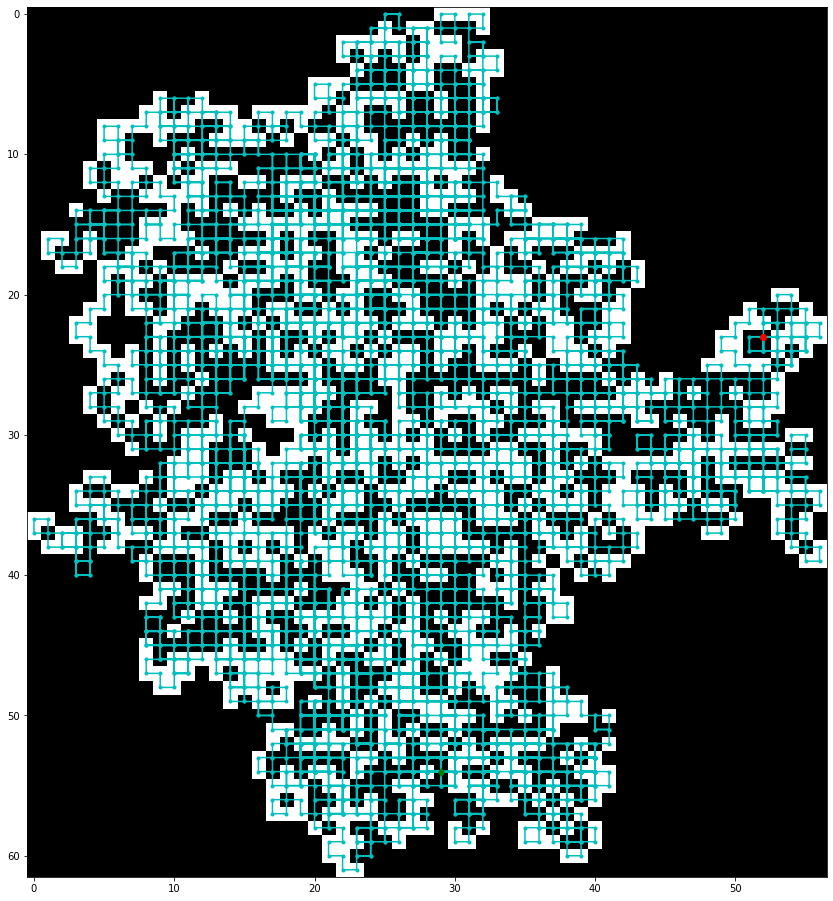

In [108]:
pixels = np.array(list(shipmap.keys()))

minx = min(pixels[:, 0])
miny = min(pixels[:, 1])
maxx = max(pixels[:, 0])
maxy = max(pixels[:, 1])

pixels[:, 0] -= minx
pixels[:, 1] -= miny

surface = np.zeros([maxx-minx+1, maxy-miny+1])
plist = np.array(paintlist)

for px in pixels:
    surface[px[0], px[1]] = shipmap[(px[0]+minx, px[1]+miny)][0]

# surf2 = np.flipud(np.fliplr(surface))
plt.figure(figsize=(16, 16))
plt.imshow(surface, cmap='gray')
plt.plot(plist[:, 1]-miny, plist[:, 0]-minx, 'c.-')
plt.plot(plist[0, 1]-miny, plist[0, 0]-minx, 'ro')
plt.plot(plist[-1, 1]-miny, plist[-1, 0]-minx, 'gd')

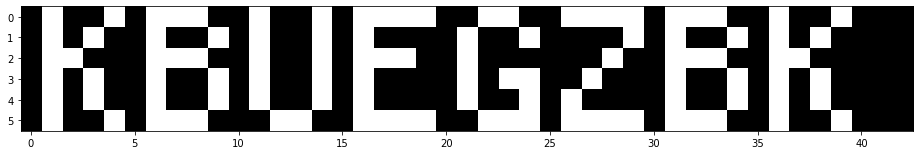

In [99]:
plt.figure(figsize=(16, 16))
plt.imshow(np.flipud(np.fliplr(surface)), cmap='gray')

KBUEGZBK

In [85]:
with open('calca_09_input.txt', 'r') as infile:
    instr = [r for r in infile][0]
program = [int(col) for col in instr.split(',')]
_, i, outbuf = intcode(program, inlist=[2])
print(outbuf)

1, 0 paint 33343 at (-3, -41)
[33343]
